In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import glob
import pickle

I0000 00:00:1695146117.779060   31024 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


# Load RGB, Depth, Intrinsics

In [17]:
paths[0]

'09-15-2023-15:02:04.pkl'

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


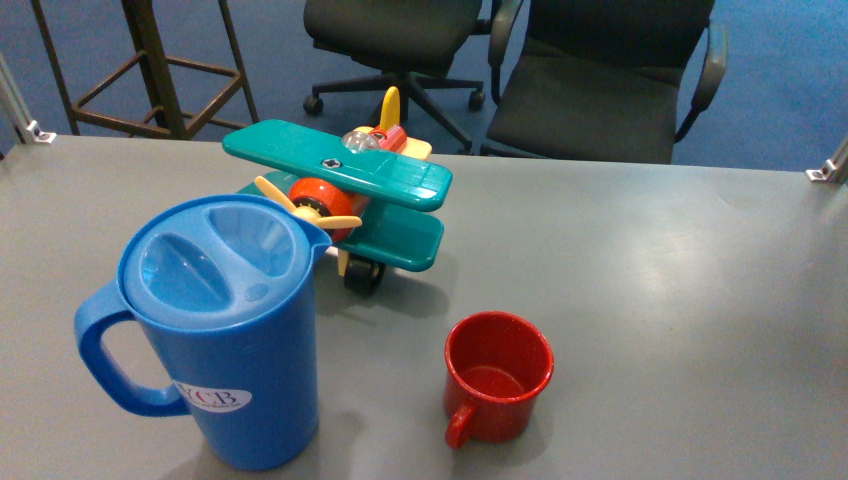

In [50]:

paths = glob.glob(
    "*.pkl"
)
all_data = pickle.load(open(paths[0], "rb"))
IDX = 1
data = all_data[IDX]

print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
far = 5.0
depth[depth < near] = far
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,near,far))
b.get_rgb_image(rgbd_original.rgb)

In [16]:
!rm 09-15-2023-15:03:24.pkl

In [35]:
scaling_factor = 0.23
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [51]:
table_pose, table_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics), jnp.eye(4), rgbd_scaled_down.intrinsics,
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)
b.clear()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", table_pose)
table_mesh = b.utils.make_cuboid_mesh(table_dims)
b.show_trimesh("table_mesh", table_mesh)
b.set_pose("table_mesh", table_pose)

In [37]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/sphere.obj"), scaling_factor=1.0/30.0)
b.show_trimesh("sphere_mesh", b.RENDERER.meshes[0], color=(0.0, 1.0, 0.0))

Increasing frame buffer size to (width, height, depth) = (224, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [52]:
def _contact_parameters_to_pose(cp, table_pose):
    return table_pose @ b.scene_graph.relative_pose_from_edge(cp, 2, b.RENDERER.model_box_dims[0])
contact_parameters_to_pose = jax.jit(_contact_parameters_to_pose)
contact_parameters_to_pose_vmap = jax.jit(jax.vmap(_contact_parameters_to_pose, in_axes=(0,None)))

def _compute_likelihood(rendered_depth):
    return b.threedp3_likelihood_old(
        b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),
        b.unproject_depth(rendered_depth, rgbd_scaled_down.intrinsics),
        0.0001,
        0.00001,
        1.0,
        1.0,
        3
    )
compute_likelihood = jax.jit(_compute_likelihood)
compute_likelihood_vmap = jax.jit(jax.vmap(_compute_likelihood))

In [63]:
contact_parameter_grid = b.utils.make_translation_grid_enumeration_3d(
    -table_dims[0]/2.0, -table_dims[1]/2.0, 0.0,
    table_dims[0]/2.0, table_dims[1]/2.0, 0.0,
    50, 50, 1
)
orange_poses_full = contact_parameters_to_pose_vmap(contact_parameter_grid, table_pose)

# for (i,p) in enumerate(orange_poses_full):
#     b.show_pose(f"{i}", p)

rendered_depth_orange_alone_all = b.RENDERER.render_many(orange_poses_full[:,None,...], jnp.array([0]))[...,2]
poses_in_field_of_view = (rendered_depth_orange_alone_all < b.RENDERER.intrinsics.far).any(-1).any(-1)
orange_poses = orange_poses_full[poses_in_field_of_view]
rendered_depth_orange_alone = rendered_depth_orange_alone_all[poses_in_field_of_view]
rendered_depth_spliced = jnp.minimum(rendered_depth_orange_alone, rgbd_scaled_down.depth[None, :,:])
scores = compute_likelihood_vmap(rendered_depth_spliced)

In [40]:
rendered_depth_spliced.shape

(2153, 110, 195)

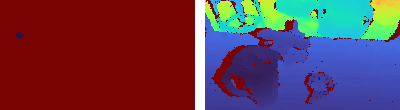

In [43]:
IDX = 100
b.show_pose("candidate_pose", orange_poses[IDX])
b.hstack_images([
    b.get_depth_image(rendered_depth_orange_alone[IDX]),
    b.get_depth_image(rendered_depth_spliced[IDX])
])

In [67]:
b.clear()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", table_pose)
b.show_trimesh("sphere_mesh", b.RENDERER.meshes[0], color=(0.0, 1.0, 0.0))

In [65]:
key = jax.random.PRNGKey(10)

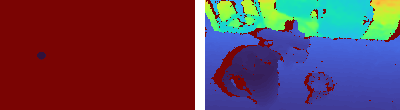

In [81]:
key = jax.random.split(key,2)[0]
sampled_indices = jax.random.categorical(key, scores, shape=(2500,))
sampled_poses = orange_poses[sampled_indices]
idx = sampled_indices[0]
b.set_pose("sphere_mesh", orange_poses[idx])
b.hstack_images([
    b.get_depth_image(rendered_depth_orange_alone[idx]),
    b.get_depth_image(rendered_depth_spliced[idx])
])

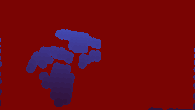

In [82]:
overlay_img = b.RENDERER.render(sampled_poses, jnp.full(sampled_poses.shape[0], 0))[...,2]
b.get_depth_image(overlay_img)